# Training and testing model

### Importing relevant Libararies, Objects and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys, os
sys.path.append(os.path.abspath(".."))

from sklearn.metrics import confusion_matrix
from torchsummary import summary
import seaborn as sns

from src.train import TrainingAlgorithm
from src.model import model
from src.utils import load_train_val_loaders

### Training Model

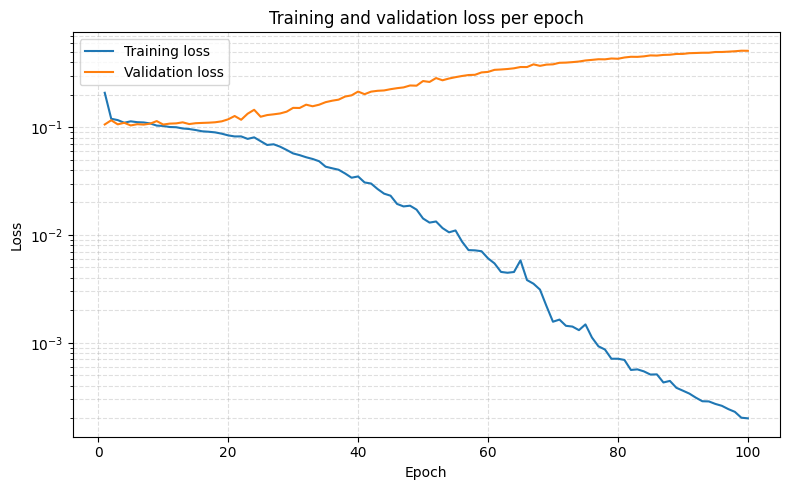

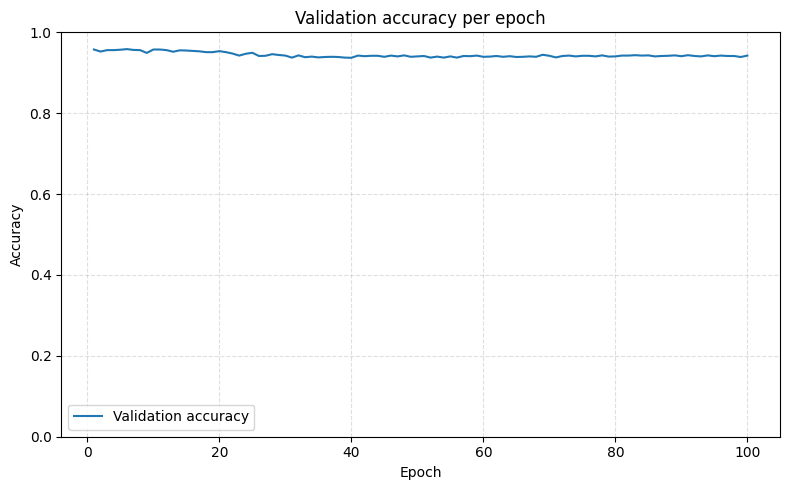

In [2]:
train_loader, val_loader = load_train_val_loaders("data")

m = model(load_weights=False)
num_epochs = 100
train_losses, val_losses, eval_accuracies = TrainingAlgorithm(
    m, train_loader, val_loader, num_epochs=num_epochs, device="cpu"
)

epochs = np.arange(1, len(train_losses)+1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy per epoch")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

### Testing submission

model.pred() needs to take the same input as the training data and output must be a one-dimensional tensor with the prediction of each input sample.

In [3]:
m_test = model() 
X = torch.load("data\input_data.pt")

y = m_test.pred(X)
print(y)

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework1\models\model_weights.pth
tensor([1.3006e-20, 1.1425e-26, 1.0000e+00,  ..., 9.3859e-26, 1.0089e-09,
        4.2195e-13])


### Summary of parameters

In [4]:
m = model(load_weights=False) 
summary(m, input_size=(1, 12, 12), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 12, 12]           4,640
         LeakyReLU-4           [-1, 32, 12, 12]               0
         AvgPool2d-5             [-1, 32, 6, 6]               0
            Linear-6                   [-1, 64]          73,792
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                    [-1, 1]              65
Total params: 78,657
Trainable params: 78,657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.30
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Confusion Matrix

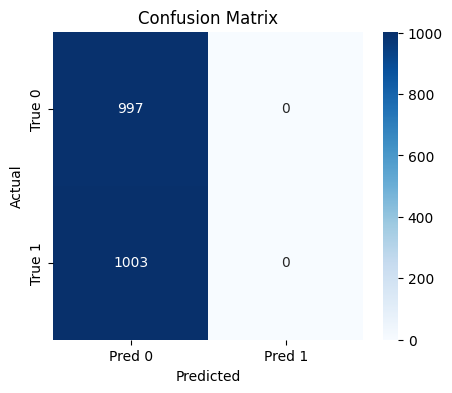

In [5]:
m.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        logits = m(X_val)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

        all_preds.append(preds.cpu())
        all_targets.append(y_val.cpu().long())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()